In [25]:
import pandas as pd
import math
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats


In [12]:
df = pd.read_csv("transaction_dataset.csv")

In [13]:
df.columns

Index(['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 

In [14]:
df.columns.shape[0] - 4

47

In [15]:
#Rename columns for easier access
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

#Remove weird stuff 
df = df.drop(columns=['unnamed:_0'])

#Remove duplicate accounts
print("Size = "+str(df.shape[0]))
df = df.drop_duplicates(subset=['address'])
print("Size without duplicates = "+str(df.shape[0]))

#Replace nan values by median 
df.fillna(df.median(numeric_only=True), inplace=True)

total = df.shape[0]
total_frauds = df["flag"].sum()
df.head()

Size = 9841
Size without duplicates = 9816


,index,address,flag,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,...,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_min_val_sent_contract,erc20_max_val_sent_contract,erc20_avg_val_sent_contract,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name,erc20_most_sent_token_type,erc20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


### fraud distribution of the dataset

#Accounts = 9816
#Flagged accounts = 2179
Percentage of flagged accounts = 22.2 %


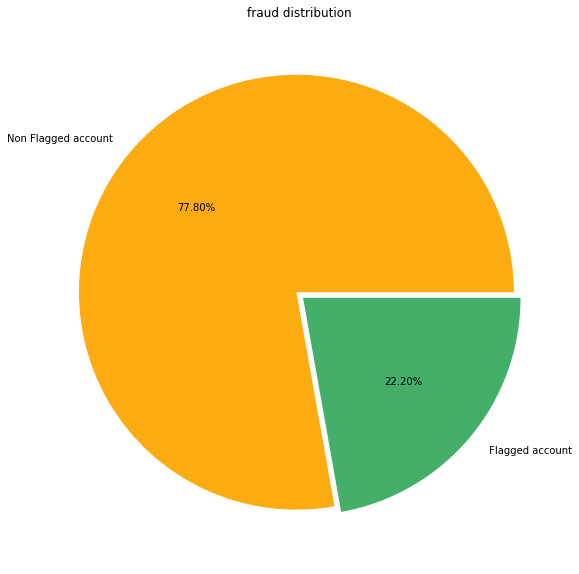

<Figure size 432x288 with 0 Axes>

In [16]:
print("#Accounts = " + str(total) + "\n" "#Flagged accounts = " + str(total_frauds))
print("Percentage of flagged accounts = " + str(round(total_frauds / total, 4) * 100) + " %")
 
pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non Flagged account', ' Flagged account']
colors = ['#FCAB10', '#44AF69']
plt.pie(x = df['flag'].value_counts(), labels = labels, colors = colors, explode=[0.02] * 2,  autopct='%.2f%%')
plt.title('fraud distribution')
plt.show()
plt.savefig("fraud_distribution_pie.png")

### facts about average transaction values, amounts, connections etc

In [17]:
# We might not want our model to be limited to token names. 
# I suggest we drop the columns -> 
token_cols = ['erc20_most_sent_token_type','erc20_most_rec_token_type']
df[token_cols].head()
df = df.drop(columns=token_cols)

###### IDEA (Alex)
# If our model uses token names to make its decision, new accounts with different tokens 
# will be incorrectly classified according to our training. 

# This is of course open to discussion 
#We can code  a f that classifies the token names as numerals and then we can reserve one numeral for all unknown token names. 

In [18]:
# Observing the columns with variances = 0
zero_var_cols = []
for col in df.columns[2:] :
    if np.var(df[col]) == 0 :
        print(col)
        zero_var_cols.append(col)
#These columns shouldn't be kept as they do not contribute to our classification problem
display(df[zero_var_cols].head(10))
df = df.drop(columns=zero_var_cols)

erc20_avg_time_between_sent_tnx
erc20_avg_time_between_rec_tnx
erc20_avg_time_between_rec_2_tnx
erc20_avg_time_between_contract_tnx
erc20_min_val_sent_contract
erc20_max_val_sent_contract
erc20_avg_val_sent_contract


,erc20_avg_time_between_sent_tnx,erc20_avg_time_between_rec_tnx,erc20_avg_time_between_rec_2_tnx,erc20_avg_time_between_contract_tnx,erc20_min_val_sent_contract,erc20_max_val_sent_contract,erc20_avg_val_sent_contract
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(df.columns)
display(df.head())

Index(['index', 'address', 'flag', 'avg_min_between_sent_tnx',
       'avg_min_between_received_tnx',
       'time_diff_between_first_and_last_(mins)', 'sent_tnx', 'received_tnx',
       'number_of_created_contracts', 'unique_received_from_addresses',
       'unique_sent_to_addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'min_value_sent_to_contract', 'max_val_sent_to_contract',
       'avg_value_sent_to_contract',
       'total_transactions_(including_tnx_to_create_contract',
       'total_ether_sent', 'total_ether_received',
       'total_ether_sent_contracts', 'total_ether_balance', 'total_erc20_tnxs',
       'erc20_total_ether_received', 'erc20_total_ether_sent',
       'erc20_total_ether_sent_contract', 'erc20_uniq_sent_addr',
       'erc20_uniq_rec_addr', 'erc20_uniq_sent_addr.1',
       'erc20_uniq_rec_contract_addr', 'erc20_min_val_rec',
       'erc20_max_val_rec', 'erc20_avg_val_rec', 'erc

,index,address,flag,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,...,erc20_uniq_sent_addr.1,erc20_uniq_rec_contract_addr,erc20_min_val_rec,erc20_max_val_rec,erc20_avg_val_rec,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.0,58.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,39.0,57.0
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,0.0,7.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,1.0,7.0
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.0,8.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,8.0
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,0.0,11.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,1.0,11.0
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.0,27.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,6.0,27.0


In [20]:
df['flag'].value_counts()
# Observing data distribution for the remaining columns
small_distr_col = []
for col in df.columns[3:] :
    if len(df[col].value_counts()) < 10:
        print(df[col].value_counts())
        print()
        small_distr_col.append(col)
#As we can see, all these columns are useless since almost no rows have different values. 
df = df.drop(columns=small_distr_col)

0.00    9814
0.02       1
0.01       1
Name: min_value_sent_to_contract, dtype: int64

0.000000    9813
0.020000       1
0.010000       1
0.046029       1
Name: max_val_sent_to_contract, dtype: int64

0.000000    9813
0.020000       1
0.010000       1
0.023014       1
Name: avg_value_sent_to_contract, dtype: int64

0.000000    9813
0.020000       1
0.010000       1
0.046029       1
Name: total_ether_sent_contracts, dtype: int64

0.0    9788
1.0      26
3.0       1
2.0       1
Name: erc20_uniq_sent_addr.1, dtype: int64



In [27]:
df.columns

Index(['index', 'address', 'flag', 'avg_min_between_sent_tnx',
       'avg_min_between_received_tnx',
       'time_diff_between_first_and_last_(mins)', 'sent_tnx', 'received_tnx',
       'number_of_created_contracts', 'unique_received_from_addresses',
       'unique_sent_to_addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'total_transactions_(including_tnx_to_create_contract',
       'total_ether_sent', 'total_ether_received', 'total_ether_balance',
       'total_erc20_tnxs', 'erc20_total_ether_received',
       'erc20_total_ether_sent', 'erc20_total_ether_sent_contract',
       'erc20_uniq_sent_addr', 'erc20_uniq_rec_addr',
       'erc20_uniq_rec_contract_addr', 'erc20_min_val_rec',
       'erc20_max_val_rec', 'erc20_avg_val_rec', 'erc20_min_val_sent',
       'erc20_max_val_sent', 'erc20_avg_val_sent',
       'erc20_uniq_sent_token_name', 'erc20_uniq_rec_token_name'],
      dtype='object')

In [22]:
df.to_csv("preprocessed_data.csv")

### 1) visualising data 

<AxesSubplot:>

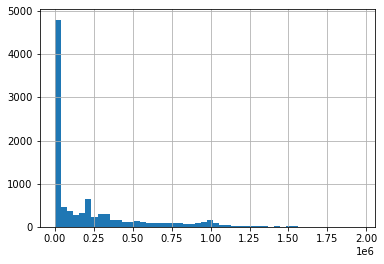

In [23]:
df['time_diff_between_first_and_last_(mins)'].hist(bins=50)

# VISUALISING DATA


 The “relationships” can be tested in different statistical ways, depending on the goal of the research.  The three most common meanings of “relationship” between/among variables are:
1.      Strength, or association, between variables = e.g., Pearson & Spearman rho correlations
2.      Statistical differences on a continuous variable by group(s) = e.g., t-test and ANOVA
3.      Statistical contribution/prediction on a variable from another(s) = regression.

## linear regression


With this, we want to identify if : 
   1. The problem can be solved with linear regression
   2. Which of the parameters are the most relevant for the prediction 


In [29]:
from sklearn.linear_model import LinearRegression

## Pearson correlation 

The Pearson correlation coefficient [1] measures the linear relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

output is (statistic, p-value) 

In [55]:
#Compute the pearson coefficient between columns to determine if columns are statistically related
def pearson_computations(): 
    total = 0
    countp = 0
    count = 0
    columns = df.columns
    print("printing the column pairs that have both sufficiently low p values and a pearson test with correlation bigger",
         "than 0.5")
    for pos, col1 in enumerate(columns):
        for col2 in columns[pos:]:
            if col1 != col2:
                if isinstance(df[col1][0], np.float64) and isinstance(df[col2][0], np.float64):
                    total+=1
                    statistic, pValue = stats.pearsonr(df[col1],df[col2])
                    if abs(statistic) > 0.5:
                        count+=1
                        #skip the values that have a small p due to the
                        # effects of Non-Normality on the Distribution of the Sample Product-Moment Correlation Coefficient
                        if pValue < 0.05:
                            countp+=1
                            print(col1, " and ", col2)
                                
    print("There is a total", total, "pearson tests that have been run on the pair of columns")
    print("Only", count, "of these values have statistical relations from the pearson test, and among these", countp,
          "also having sufficiently small p values")


In [56]:
pearson_computations()

printing the column pairs that have both sufficiently low p values and a pearson test with correlation bigger than 0.5
max_value_received  and  avg_val_received
min_val_sent  and  avg_val_sent
max_val_sent  and  total_ether_balance
total_ether_sent  and  total_ether_received
total_erc20_tnxs  and  erc20_uniq_sent_addr
total_erc20_tnxs  and  erc20_uniq_rec_addr
erc20_total_ether_received  and  erc20_max_val_rec
erc20_total_ether_received  and  erc20_avg_val_rec
erc20_total_ether_sent  and  erc20_min_val_sent
erc20_total_ether_sent  and  erc20_max_val_sent
erc20_total_ether_sent  and  erc20_avg_val_sent
erc20_uniq_sent_addr  and  erc20_uniq_rec_addr
erc20_uniq_rec_contract_addr  and  erc20_uniq_sent_token_name
erc20_uniq_rec_contract_addr  and  erc20_uniq_rec_token_name
erc20_max_val_rec  and  erc20_avg_val_rec
erc20_min_val_sent  and  erc20_max_val_sent
erc20_min_val_sent  and  erc20_avg_val_sent
erc20_max_val_sent  and  erc20_avg_val_sent
erc20_uniq_sent_token_name  and  erc20_uniq_rec